In [1]:
import numpy as np
import scipy
import veloxchem as vlx

In [2]:
h2o_xyz = """3

O    0.000000000000        0.000000000000        0.000000000000
H    0.000000000000        0.740848095288        0.582094932012
H    0.000000000000       -0.740848095288        0.582094932012
"""

molecule = vlx.Molecule.read_xyz_string(h2o_xyz)
basis = vlx.MolecularBasis.read(molecule, "cc-pVDZ", ostream=None)

In [3]:
molecule.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [4]:
scf_drv = vlx.ScfRestrictedDriver()
scf_drv.ostream.mute()
scf_results = scf_drv.compute(molecule, basis)

In [5]:
print(f"Final HF energy: {scf_drv.get_scf_energy() : 12.8f} Hartree")

Final HF energy: -76.02698419 Hartree


In [6]:
norb = basis.get_dimensions_of_basis()
nocc = molecule.number_of_alpha_electrons()
V_nuc = molecule.nuclear_repulsion_energy()

print("Number of contracted basis functions:", norb)
print("Number of doubly occupied molecular orbitals:", nocc)
print(f"Nuclear repulsion energy (in a.u.): {V_nuc : 14.12f}")

Number of contracted basis functions: 24
Number of doubly occupied molecular orbitals: 5
Nuclear repulsion energy (in a.u.):  9.343638157670


In [7]:
# overlap matrix
S = vlx.compute_overlap_integrals(molecule, basis)

# one-electron Hamiltonian
T = vlx.compute_kinetic_energy_integrals(molecule, basis)

V = vlx.compute_nuclear_potential_integrals(molecule, basis)

h = T + V

# two-electron Hamiltonian
fock_drv = vlx.FockDriver()
g = fock_drv.compute_eri(molecule, basis)

In [8]:
# initial guess from core Hamiltonian
epsilon, C = scipy.linalg.eigh(h, S)

In [9]:
max_iter = 50
conv_thresh = 1e-6

error_RH = []

In [10]:
print("iter      SCF energy    Error norm")

for iter in range(max_iter):

    D = np.einsum("ik,jk->ij", C[:, :nocc], C[:, :nocc])

    J = np.einsum("ijkl,kl->ij", g, D)
    K = np.einsum("ilkj,kl->ij", g, D)
    F = h + 2 * J - K

    E = np.einsum("ij,ij->", h + F, D) + V_nuc

    # compute convergence metric
    e_mat = np.linalg.multi_dot([F, D, S]) - np.linalg.multi_dot([S, D, F])
    e_vec = e_mat.reshape(-1)
    error = np.linalg.norm(e_vec)

    print(f"{iter:>2d}  {E:16.8f}  {error:10.2e}")
    error_RH.append(error)

    if error < conv_thresh:
        print("SCF iterations converged!")
        break

    epsilon, C = scipy.linalg.eigh(F, S)

iter      SCF energy    Error norm
 0      -68.84975229    3.09e+00
 1      -69.95937641    2.88e+00
 2      -73.34743276    2.83e+00
 3      -73.46688910    2.23e+00
 4      -74.74058933    2.18e+00
 5      -75.55859127    1.41e+00
 6      -75.86908635    8.26e-01
 7      -75.97444165    4.82e-01
 8      -76.00992921    2.74e-01
 9      -76.02143957    1.57e-01
10      -76.02519173    8.89e-02
11      -76.02640379    5.06e-02
12      -76.02679653    2.88e-02
13      -76.02692347    1.64e-02
14      -76.02696455    9.31e-03
15      -76.02697784    5.30e-03
16      -76.02698213    3.01e-03
17      -76.02698352    1.71e-03
18      -76.02698397    9.74e-04
19      -76.02698412    5.54e-04
20      -76.02698416    3.15e-04
21      -76.02698418    1.79e-04
22      -76.02698418    1.02e-04
23      -76.02698419    5.80e-05
24      -76.02698419    3.30e-05
25      -76.02698419    1.88e-05
26      -76.02698419    1.07e-05
27      -76.02698419    6.07e-06
28      -76.02698419    3.45e-06
29      

In [11]:
def c1diis(F_mats, e_vecs):

    n = len(e_vecs)

    # build DIIS matrix
    B = -np.ones((n + 1, n + 1))
    B[n, n] = 0

    for i in range(n):
        for j in range(n):
            B[i, j] = np.dot(e_vecs[i], e_vecs[j])

    b = np.zeros(n + 1)
    b[n] = -1

    w = np.matmul(np.linalg.inv(B), b)

    F_diis = np.zeros((norb, norb))
    for i in range(n):
        F_diis += w[i] * F_mats[i]

    return F_diis

In [12]:
e_vecs = []
F_mats = []
error_DIIS = []

# initial guess from core Hamiltonian
epsilon, C = scipy.linalg.eigh(h, S)

print("iter      SCF energy    Error norm")

for iter in range(max_iter):

    D = np.einsum("ik,jk->ij", C[:, :nocc], C[:, :nocc])

    J = np.einsum("ijkl,kl->ij", g, D)
    K = np.einsum("ilkj,kl->ij", g, D)
    F = h + 2 * J - K
    F_mats.append(F)

    E = np.einsum("ij,ij->", h + F, D) + V_nuc

    # compute convergence metric
    e_mat = np.linalg.multi_dot([F, D, S]) - np.linalg.multi_dot([S, D, F])
    e_vecs.append(e_mat.reshape(-1))
    error = np.linalg.norm(e_vecs[-1])

    print(f"{iter:>2d}  {E:16.8f}  {error:10.2e}")
    error_DIIS.append(error)

    if error < conv_thresh:
        print("SCF iterations converged!")
        break

    F = c1diis(F_mats, e_vecs)
    epsilon, C = scipy.linalg.eigh(F, S)

iter      SCF energy    Error norm
 0      -68.84975229    3.09e+00
 1      -69.95937641    2.88e+00
 2      -75.88501761    8.37e-01
 3      -75.97016719    5.18e-01
 4      -76.01483442    2.34e-01
 5      -76.02676704    3.29e-02
 6      -76.02698021    3.32e-03
 7      -76.02698392    8.01e-04
 8      -76.02698418    2.04e-04
 9      -76.02698419    6.97e-05
10      -76.02698419    2.06e-06
11      -76.02698419    5.43e-07
SCF iterations converged!


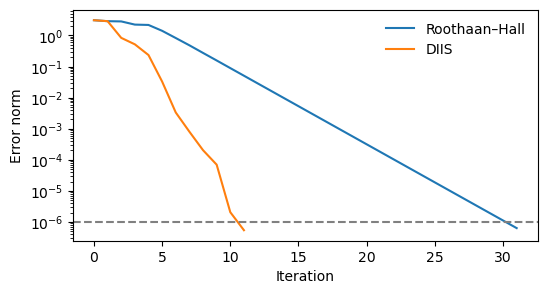

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))

plt.plot(error_RH, label="Roothaan–Hall")
plt.plot(error_DIIS, label="DIIS")

plt.yscale("log")

plt.axhline(y=conv_thresh, linestyle="--", color="grey")
plt.legend(frameon=False)
plt.xlabel("Iteration")
plt.ylabel(r"Error norm")

plt.show()